In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import theseus as th
import matplotlib.pyplot as plt

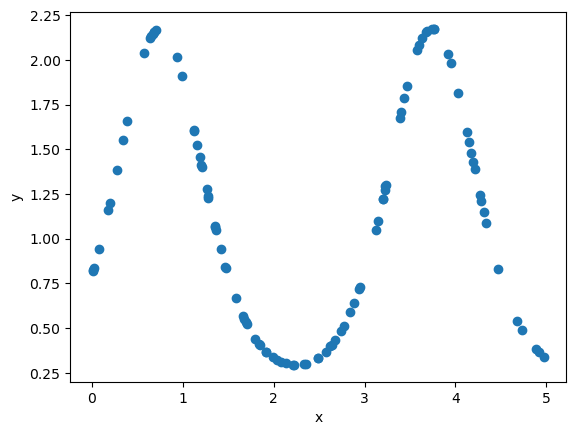

In [59]:
target_fn_params = {
    'a': 0.8,
    'b': 2.1,
}

def target_fn(x, *params):
    a, b = params
    return a * torch.exp(torch.sin(b * x))

def generate_data(n = 100, *params):
    x = torch.rand(n) * 5
    y = target_fn(x, *params)
    noise = torch.randn(n) * 0.001
    return torch.stack([x, y + noise], dim=1)

data = generate_data(100, *target_fn_params.values())
plt.scatter(data[:, 0], data[:, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [60]:
optim_vars = [th.Vector(1, name=n) for n in target_fn_params.keys()]
aux_vars = [
    (th.Variable(x.view(1, -1), f'x{i}'),
     th.Variable(y.view(1, -1), f'y{i}'))
    for i, (x, y) in enumerate(data)
]

In [74]:
def err_fn(optim_vars: list[th.Variable],
             aux_vars: list[th.Variable]):
    a, b = [v.tensor for v in optim_vars]
    x, y = [v.tensor for v in aux_vars]
    y_hat = target_fn(x, a, b)
    return y - y_hat

costs = []
for i, (x, y) in enumerate(aux_vars):
    cost = th.AutoDiffCostFunction(
        optim_vars, err_fn, 1,
        aux_vars=(x, y), name=f'err_fn_{i}',
    )
    costs.append(cost)

obj = th.Objective()
for c in costs:
    obj.add(c)

opt = th.LevenbergMarquardt(
    obj, max_iterations=500, step_size=0.5
)

th_opt = th.TheseusLayer(opt)

In [75]:

th_input = {}

for k in target_fn_params.keys():
    th_input[k] = torch.tensor(2)

for i, (x, y) in enumerate(data):
    th_input[f'x{i}'] = x
    th_input[f'y{i}'] = y

for k in th_input.keys():
    th_input[k] = th_input[k].view(1, -1).float()

with torch.no_grad():
    updated_inputs, info = th_opt.forward(
        th_input, optimizer_kwargs={"track_best_solution": True, "verbose":True})

print("Best solution:", info.best_solution)


Nonlinear optimizer. Iteration: 0. Error: 210.19924926757812
Nonlinear optimizer. Iteration: 1. Error: 53.15750503540039
Nonlinear optimizer. Iteration: 2. Error: 13.513398170471191
Nonlinear optimizer. Iteration: 3. Error: 3.440016269683838
Nonlinear optimizer. Iteration: 4. Error: 0.8727900385856628
Nonlinear optimizer. Iteration: 5. Error: 0.22035767138004303
Nonlinear optimizer. Iteration: 6. Error: 0.05543527007102966
Nonlinear optimizer. Iteration: 7. Error: 0.0139359962195158
Nonlinear optimizer. Iteration: 8. Error: 0.003523972351104021
Nonlinear optimizer. Iteration: 9. Error: 0.0009160689660347998
Nonlinear optimizer. Iteration: 10. Error: 0.00026342947967350483
Nonlinear optimizer. Iteration: 11. Error: 0.00010016094165621325
Nonlinear optimizer. Iteration: 12. Error: 5.9351714298827574e-05
Nonlinear optimizer. Iteration: 13. Error: 4.9141235649585724e-05
Nonlinear optimizer. Iteration: 14. Error: 4.658563921111636e-05
Nonlinear optimizer. Iteration: 15. Error: 4.59498442069

Text(0, 0.5, 'y')

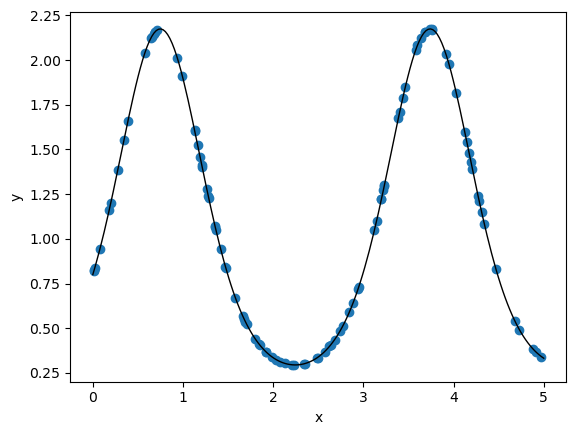

In [77]:
# Plot the optimized function
fig, ax = plt.subplots()
ax.scatter(data[:, 0], data[:, 1]);

a, b = [info.best_solution[n].squeeze() for n in 'ab']
x = torch.linspace(0., 5., steps=200)
y = target_fn(x, a, b)
ax.plot(x, y, color='k', lw=1, linestyle='-', label='fitted curve')
#ax.legend()

ax.set_xlabel('x')
ax.set_ylabel('y')